# Introduction

In scikit-learn there is a nice function which can be used to perform a k-fold cross validation.

References:
- https://scikit-learn.org/stable/modules/cross_validation.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score 

But how do you perform a k-fold CV when working with TensorFlow/Keras or PyTorch?

This example shows how to do this!

# k-fold CV with Keras

Path to dataset files: /home/juebrauer/.cache/kagglehub/datasets/prathamtripathi/regression-with-neural-networking/versions/1
   Cement  Blast Furnace Slag  Fly Ash  Water  Superplasticizer  \
0   540.0                 0.0      0.0  162.0               2.5   
1   540.0                 0.0      0.0  162.0               2.5   
2   332.5               142.5      0.0  228.0               0.0   
3   332.5               142.5      0.0  228.0               0.0   
4   198.6               132.4      0.0  192.0               0.0   

   Coarse Aggregate  Fine Aggregate  Age  Strength  
0            1040.0           676.0   28     79.99  
1            1055.0           676.0   28     61.89  
2             932.0           594.0  270     40.27  
3             932.0           594.0  365     41.05  
4             978.4           825.5  360     44.30  

Shape: (1030, 9)

==================== Fold 1/5 ====================
MLP stopped after 286 epochs
Fold 1 MAPE - MLP: 11.89%
Fold 1 MAPE -  LR: 17.97%
Di

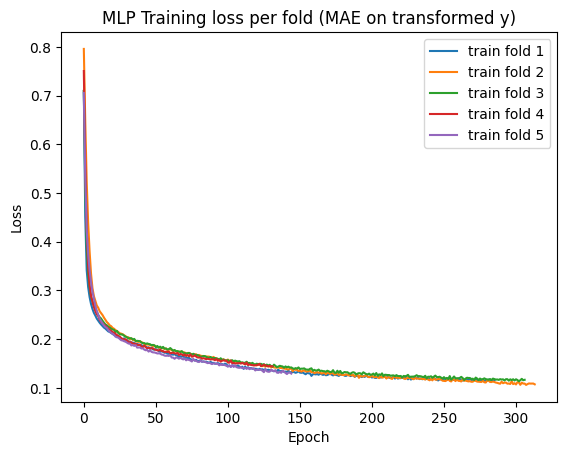

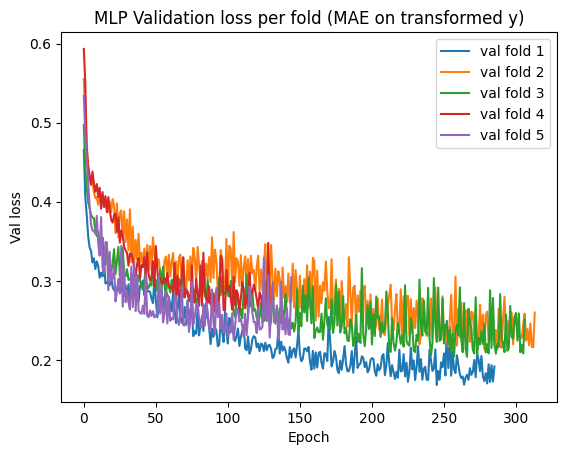

In [4]:
# ============================================================
# Concrete strength prediction with:
# - MLP (Keras) + KFold CV + EarlyStopping
# - Linear Regression baseline (same folds)
# ============================================================

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # GPU deaktivieren

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression

import tensorflow as tf
import kagglehub


# -----------------------------
# Reproducibility
# -----------------------------
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


# -----------------------------
# 1) Load dataset via kagglehub
# -----------------------------
path = kagglehub.dataset_download("prathamtripathi/regression-with-neural-networking")
print("Path to dataset files:", path)

df = pd.read_csv(os.path.join(path, "concrete_data.csv"))
print(df.head())
print("\nShape:", df.shape)


# -----------------------------
# 2) Define inputs/target
# -----------------------------
target_feature = "Strength"
X = df.drop(columns=[target_feature]).values
y = df[[target_feature]].values  # 2D for PowerTransformer inverse_transform

nr_inputs = X.shape[1]


# -----------------------------
# 3) Build MLP model factory
# -----------------------------
def build_model(n_inputs: int) -> tf.keras.Model:
    model = tf.keras.Sequential(name="ConcreteStrengthPredictor")
    model.add(tf.keras.layers.InputLayer(shape=(n_inputs,)))
    model.add(tf.keras.layers.Dense(40, activation="relu", name="hidden1"))
    model.add(tf.keras.layers.Dense(20, activation="relu", name="hidden2"))
    model.add(tf.keras.layers.Dense(10, activation="relu", name="hidden3"))
    model.add(tf.keras.layers.Dense(1, name="output"))
    model.compile(optimizer="rmsprop", loss="mae")
    return model


# -----------------------------
# 4) KFold Cross-Validation
# -----------------------------
N_SPLITS = 5
EPOCHS_MAX = 2000
BATCH_SIZE = 32
VAL_SPLIT = 0.1
PATIENCE = 40
MIN_DELTA = 0.0

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

mlp_mapes = []
lr_mapes = []
mlp_epochs = []
mlp_histories = []

for fold, (tr_idx, te_idx) in enumerate(kf.split(X), start=1):
    print(f"\n==================== Fold {fold}/{N_SPLITS} ====================")

    # Split
    X_tr, X_te = X[tr_idx], X[te_idx]
    y_tr, y_te = y[tr_idx], y[te_idx]

    # Scale X and y (fit only on training fold!)
    s_in = PowerTransformer()
    s_out = PowerTransformer()

    X_tr_s = s_in.fit_transform(X_tr)
    y_tr_s = s_out.fit_transform(y_tr)

    X_te_s = s_in.transform(X_te)

    # ---------- MLP ----------
    model = build_model(nr_inputs)

    early = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=PATIENCE,
        min_delta=MIN_DELTA,
        restore_best_weights=True,
        verbose=0
    )

    history = model.fit(
        X_tr_s, y_tr_s,
        validation_split=VAL_SPLIT,
        epochs=EPOCHS_MAX,
        batch_size=BATCH_SIZE,
        callbacks=[early],
        verbose=0
    )

    preds_mlp_s = model.predict(X_te_s, verbose=0)
    preds_mlp = s_out.inverse_transform(preds_mlp_s)
    mape_mlp = mean_absolute_percentage_error(y_te, preds_mlp.flatten()) * 100

    mlp_mapes.append(mape_mlp)
    mlp_epochs.append(len(history.history["loss"]))
    mlp_histories.append(history.history)

    # ---------- Linear Regression ----------
    # Fit on the SAME scaled data + same y-transform to be comparable
    lr = LinearRegression()
    lr.fit(X_tr_s, y_tr_s)  # y_tr_s is 2D -> OK

    preds_lr_s = lr.predict(X_te_s)            # returns (n,1)
    preds_lr = s_out.inverse_transform(preds_lr_s)
    mape_lr = mean_absolute_percentage_error(y_te, preds_lr.flatten()) * 100

    lr_mapes.append(mape_lr)

    # ---------- Print fold results ----------
    print(f"MLP stopped after {mlp_epochs[-1]} epochs")
    print(f"Fold {fold} MAPE - MLP: {mape_mlp:.2f}%")
    print(f"Fold {fold} MAPE -  LR: {mape_lr:.2f}%")
    print(f"Difference (LR - MLP): {mape_lr - mape_mlp:.2f}%  (positive => MLP better)")


# -----------------------------
# 5) Summaries
# -----------------------------
mlp_mapes_np = np.array(mlp_mapes)
lr_mapes_np = np.array(lr_mapes)

print("\n==================== CV Summary ====================")
print("MLP fold MAPEs (%):", np.round(mlp_mapes_np, 2))
print(f"MLP mean MAPE: {mlp_mapes_np.mean():.2f}%  | std: {mlp_mapes_np.std(ddof=0):.2f}%")
print("LR  fold MAPEs (%):", np.round(lr_mapes_np, 2))
print(f"LR  mean MAPE: {lr_mapes_np.mean():.2f}%  | std: {lr_mapes_np.std(ddof=0):.2f}%")

diff = lr_mapes_np - mlp_mapes_np
print("\nFold diffs (LR - MLP) (%-points):", np.round(diff, 2))
print(f"Mean diff (LR - MLP): {diff.mean():.2f} %-points  (positive => MLP better)")

print("\nEpochs per fold (MLP):", mlp_epochs)
print(f"Mean epochs: {np.mean(mlp_epochs):.1f}")


# -----------------------------
# 6) Optional: plot loss curves per fold
# -----------------------------
plt.figure()
for i, h in enumerate(mlp_histories, start=1):
    plt.plot(h["loss"], label=f"train fold {i}")
plt.title("MLP Training loss per fold (MAE on transformed y)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
for i, h in enumerate(mlp_histories, start=1):
    plt.plot(h["val_loss"], label=f"val fold {i}")
plt.title("MLP Validation loss per fold (MAE on transformed y)")
plt.xlabel("Epoch")
plt.ylabel("Val loss")
plt.legend()
plt.show()
